# Creating your own dataset from Google Images

*inspired by: Jeremy Howard*

In [1]:
from fastai.vision import *

## Get a list of URLs
Search using [Google Images](http://images.google.com) for "new york" and "wroclaw" and save it in .csv as described below

How to fetch images you see on google search as download.csv

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

## Fetch

In [3]:
path = Path('data')/"interior"

In [4]:
list(path.glob("*.csv"))

[PosixPath('data/interior/lecture-hall.csv'),
 PosixPath('data/interior/kitchen.csv'),
 PosixPath('data/interior/hotelroom.csv')]

In [5]:
classes=[]
for f in path.glob("*.csv"):
    d = path/f.stem
    classes.append(f.stem)
    if not d.exists():
        d.mkdir(parents=True)
        print("Fetching", f)
        download_images(f, d, max_pics=200)

Fetching data/interior/lecture-hall.csv


Error https://dcs.rutgers.edu/sites/default/files/images/dcs/marshall-catch-lightbox.jpg HTTPSConnectionPool(host='dcs.rutgers.edu', port=443): Max retries exceeded with url: /sites/default/files/images/dcs/marshall-catch-lightbox.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe74654f2e8>, 'Connection to dcs.rutgers.edu timed out. (connect timeout=4)'))
Fetching data/interior/kitchen.csv


Error https://www.thekitchenstore.net/wp-content/uploads/2018/04/custom-kitchen-cabinets-in-santa-monica-ca-1600x650.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://webassets.inman.com/wp-content/uploads/2018/01/Untitled-design-56-1984x880.png HTTPSConnectionPool(host='webassets.inman.com', port=443): Read timed out. (read timeout=4)
Error https://www.thekitchenstore.net/wp-content/uploads/2018/04/custom-kitchen-remodeling-in-santa-monica-ca-1600x650.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching data/interior/hotelroom.csv


Error https://viejas.com/wp-content/uploads/2018/01/luxury-king-bed.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://viejas.com/wp-content/uploads/2018/01/delux-queen-beds-1-495x377.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


In [6]:
classes

['lecture-hall', 'kitchen', 'hotelroom']

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

lecture-hall


cannot identify image file <_io.BufferedReader name='data/interior/lecture-hall/00000074.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/lecture-hall/00000088.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/lecture-hall/00000030.jpg'>
Image data/interior/lecture-hall/00000093.jpg has 4 instead of 3
kitchen


cannot identify image file <_io.BufferedReader name='data/interior/kitchen/00000004.jpeg'>
cannot identify image file <_io.BufferedReader name='data/interior/kitchen/00000073.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/kitchen/00000013.jpeg'>
cannot identify image file <_io.BufferedReader name='data/interior/kitchen/00000081.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/kitchen/00000066.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/kitchen/00000082.jpg'>
hotelroom


cannot identify image file <_io.BufferedReader name='data/interior/hotelroom/00000076.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/hotelroom/00000034.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/hotelroom/00000015.jpg'>
cannot identify image file <_io.BufferedReader name='data/interior/hotelroom/00000010.jpg'>


## View data

In [8]:
path.ls()

[PosixPath('data/interior/lecture-hall.csv'),
 PosixPath('data/interior/kitchen'),
 PosixPath('data/interior/hotelroom'),
 PosixPath('data/interior/lecture-hall'),
 PosixPath('data/interior/kitchen.csv'),
 PosixPath('data/interior/hotelroom.csv')]

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(flip_vert=True, ), size=224, num_workers=4, classes=classes).normalize(imagenet_stats)

In [10]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(".", folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [11]:
data.classes

['lecture-hall', 'kitchen', 'hotelroom']

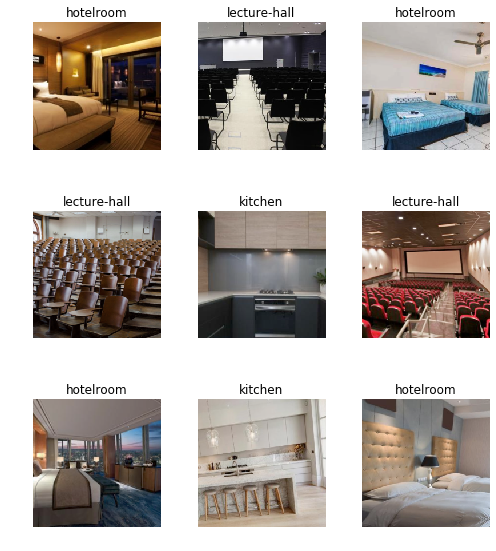

In [12]:
data.show_batch(rows=3, figsize=(7,8))

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['lecture-hall', 'kitchen', 'hotelroom'], 3, 223, 55)

In [43]:
np.unique([str(c) for c in data.train_ds.y], return_counts=True)

(array(['hotelroom', 'kitchen', 'lecture-hall'], dtype='<U12'),
 array([77, 71, 75]))

## Train model

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.330344,0.699425,0.309091
2,0.902946,0.299069,0.109091
3,0.654352,0.235615,0.090909
4,0.526714,0.224791,0.072727


In [16]:
learn.save('stage-1')

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


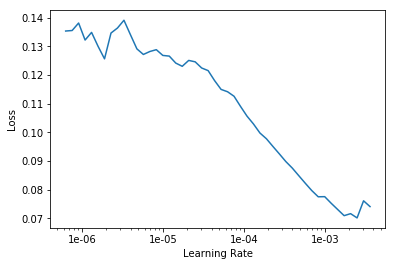

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.144011,0.232492,0.090909
2,0.120380,0.221390,0.090909


In [21]:
learn.save('stage-2')

## Interpretation

In [22]:
learn.load('stage-2');

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

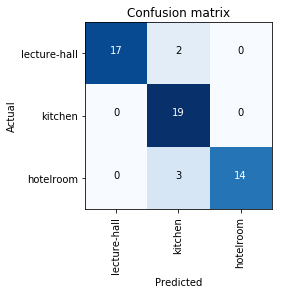

In [24]:
interp.plot_confusion_matrix()

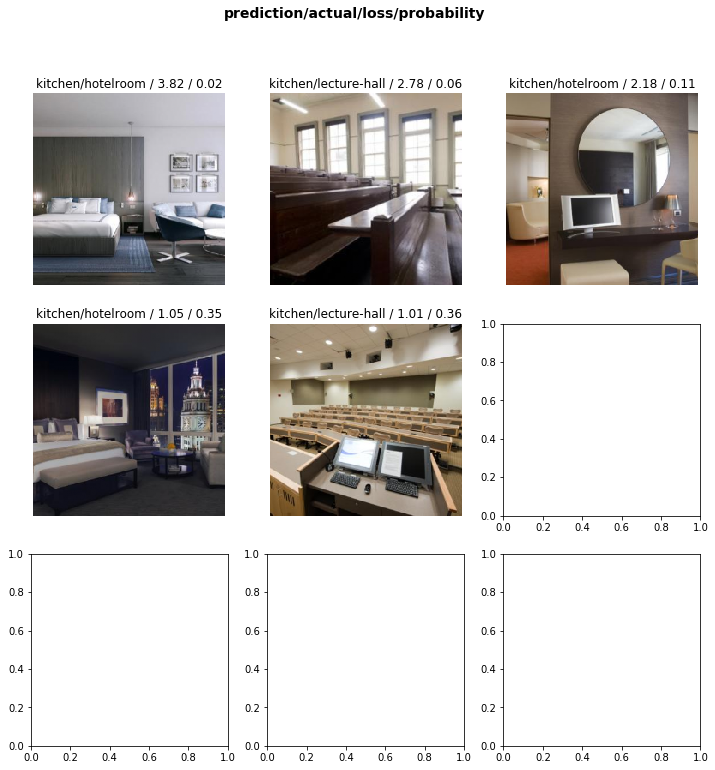

In [32]:
interp.plot_top_losses(5)

# Test your prediction

In [28]:
fn=path.parent/"Int1.jpeg"
!ls {fn}

data/Int1.jpeg


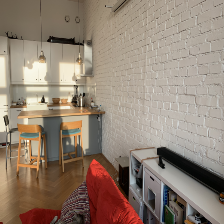

In [29]:
img=open_image(fn).resize(224);img

In [30]:
type(learn.data.train_ds.x)

fastai.vision.data.ImageItemList

In [31]:
learn.predict(img)

(Category kitchen, tensor(1), tensor([0.0063, 0.9470, 0.0468]))